# Segmentation sémantique - Solutions

Cette session de pratique a pour objectif d’extraire automatiquement les empreintes des bâtiments à partir d’images aériennes. Nous voulons approximer la fonction qui mappe les images d’entrée à une prédiction binaire pour chaque pixel (segmentation sémantique) en utilisant l’architecture de réseau de neurones convolutionnel U-Net [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28).

Les données d’image consistent en 3347 images raster en couleur de dimensions 256x256x3 utilisant le système de projection NAD83 (EPSG:26986). Chaque raster représente une zone de 300 mètres carrés. Les données labélisées se composent des empreintes des bâtiments extraites depuis [OpenStreetMap](https://www.openstreetmap.org/relation/61315) et convertis en raster binaire. Les données non formatées ont été fournies par Minh (2013) et peuvent être consultées sur son [site web](http://www.cs.toronto.edu/~vmnih/data/).

![U-Net model](https://www.dropbox.com/scl/fi/l5c0vxerw1ym034hmi11b/segmentation_model.jpg?rlkey=8pggpqz3t3w7x3yb97k6su95z&dl=1)

In [2]:
# Packages
import numpy as np
import tensorflow
import os
import shutil

from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils
from sklearn import metrics as skmetrics
from urllib import request

# Package manquant
!pip install rasterio

# Chemin du répertoire courant
# os.chdir(os.path.dirname(__file__))

# Vérification de la librairie TensorFlow
print('TensorFlow version:', tensorflow.__version__)
print('GPU available:', len(tensorflow.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
GPU available: 1


In [3]:
# Utilitaires
def download_data() -> None:
    '''Downloads data folder'''
    if os.path.basename(os.getcwd()) != 'data':
        request.urlretrieve('https://www.dropbox.com/scl/fo/d81z4wgz5kqi10u8ig2c2/AJ8pxCLdfvZEVoWHMQWwXCA?rlkey=l8r1xavgjmkq9du89wdex88k1&dl=1', 'data.zip')
        shutil.unpack_archive('data.zip', 'data')
        os.remove('data.zip')    
        os.chdir('data')

# Chemins
paths = dict(
    images_train='training/images',
    labels_train='training/labels',
    images_valid='validation/images',
    labels_valid='validation/labels',
    images_test= 'test/images',
    labels_test= 'test/labels'
)

1. Chargez les images et les labels pour les échantillons d'entraînement et de validation sous forme de `numpy.ndarray` avec des dimensions $n \times h \times w \times d$. Utilisez les fonctions utilitaires fournies `search_files` et `read_raster`. Normalisez les images entre 0 et 1 et formatez les labels en type *float*.

In [4]:
# Première exécution seulement
download_data()
from segmentation_utilities import *

# Charge et formatte des données d'entraînement
images_train = np.array([read_raster(file) for file in search_files(paths['images_train'], 'tif$')])
labels_train = np.array([read_raster(file) for file in search_files(paths['labels_train'], 'tif$')])
images_train = images_train / 255
labels_train = labels_train.astype(float)

# Charge et formatte des données de validation
images_valid = np.array([read_raster(file) for file in search_files(paths['images_valid'], 'tif$')])
labels_valid = np.array([read_raster(file) for file in search_files(paths['labels_valid'], 'tif$')])
images_valid = images_valid / 255
labels_valid = labels_valid.astype(float)

2.	Pour l'échantillon d’entraînement, vérifiez les dimensions des images et des labels. Affichez plusieurs paires correspondantes d'images et de labels pour vous assurer de leur correspondance. Vous pouvez utiliser la fonction utilitaire fournie `compare`.

Images dimensions: (2343, 256, 256, 3)
Labels dimensions: (2343, 256, 256, 1)


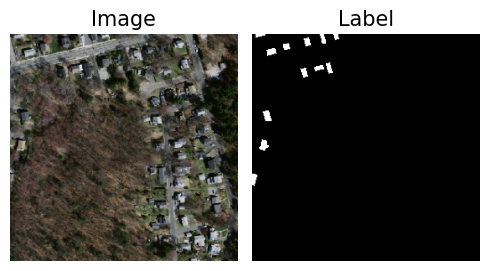

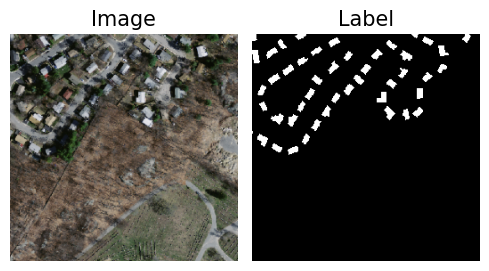

In [5]:
# Affiche les dimensions des images et des labels
print('Images dimensions:', images_train.shape)
print('Labels dimensions:', labels_train.shape)

# Affiche les images et les labels
for i in np.random.choice(range(len(images_train)), 2, replace=False):
    compare(images=[images_train[i], labels_train[i]], titles=['Image', 'Label'])

3. En utilisant l'API fonctionnelle de Tensorflow Keras, définissez un modèle U-Net simplifié avec le nombre de noyaux indiqué dans la figure ci-dessus (c'est-à-dire 16, 32, 64, 128, 256, $\dots$). Il existe de nombreux exemples d'implémentation de U-Nets utilisant Keras.

In [6]:
# Bloc convolutif
def convolution_block(input, filters:int, dropout:float, training:bool, name:str):
    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False, kernel_initializer='he_normal', name=f'{name}_convolution1')(input)
    x = layers.Activation(activation='relu', name=f'{name}_activation1')(x)
    x = layers.BatchNormalization(name=f'{name}_normalisation1')(x)
    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False, kernel_initializer='he_normal', name=f'{name}_convolution2')(x)
    x = layers.Activation(activation='relu', name=f'{name}_activation2')(x)
    x = layers.BatchNormalization(name=f'{name}_normalisation2')(x)
    x = layers.SpatialDropout2D(rate=dropout, name=f'{name}_dropout')(x, training=training)
    return x

# Bloc encodeur
def encoder_block(input, filters:int, dropout:float, training:bool, name:str):
    x = convolution_block(input=input, filters=filters, dropout=dropout, training=training, name=name)
    p = layers.MaxPool2D(pool_size=(2, 2), name=f'{name}_pooling')(x)
    return x, p

# Bloc décodeur
def decoder_block(input, skip, filters:int, dropout:float, training:bool, name:str):
    x = layers.Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2, 2), padding='same', name=f'{name}_transpose')(input)
    x = layers.Concatenate(name=f'{name}_concatenate')([x, skip])
    x = convolution_block(input=x, filters=filters, dropout=dropout, training=training, name=name)
    return x

# Modèle U-Net
def init_unet(input_shape:dict, n_outputs:int, filters:int, dropout:float=0.0, training:bool=False):
    # Données d'entrée
    inputs = layers.Input(input_shape)
    # Blocs encodeurs
    s1, p1 = encoder_block(input=inputs, filters=1*filters, dropout=dropout, training=training, name='encoder1')
    s2, p2 = encoder_block(input=p1,     filters=2*filters, dropout=dropout, training=training, name='encoder2')
    s3, p3 = encoder_block(input=p2,     filters=4*filters, dropout=dropout, training=training, name='encoder3')
    s4, p4 = encoder_block(input=p3,     filters=8*filters, dropout=dropout, training=training, name='encoder4')
    # Bloc central
    b1 = convolution_block(input=p4, filters=16*filters, dropout=dropout, training=training, name='bottleneck')
    # Blocs décodeurs
    d1 = decoder_block(input=b1, skip=s4, filters=8*filters, dropout=dropout, training=training, name='decoder1')
    d2 = decoder_block(input=d1, skip=s3, filters=4*filters, dropout=dropout, training=training, name='decoder2')
    d3 = decoder_block(input=d2, skip=s2, filters=2*filters, dropout=dropout, training=training, name='decoder3')
    d4 = decoder_block(input=d3, skip=s1, filters=1*filters, dropout=dropout, training=training, name='decoder4')
    # Données de sortie
    outputs = layers.Conv2D(filters=n_outputs, kernel_size=(1, 1), padding='same', activation='sigmoid')(d4)
    # Modèle
    model = models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

4. Initialisez et compilez le modèle en utilisant l’algorithme d’optimisation choisi et la fonction de perte appropriée. Vous pouvez éventuellement utiliser la version focalisée de la fonction de perte pour tenir compte du déséquilibre des classes dans les données d’entraînement. Affichez la structure du modèle en utilisant la méthode `summary`.

In [7]:
# Initialise le modèle
model = init_unet(
    input_shape=images_train.shape[1:], 
    n_outputs=labels_train.shape[-1], 
    filters=16)

# Compile le modèle
model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-4), 
    loss=losses.BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.5)])

# Visualise le modèle
model.summary()

2024-06-09 23:11:49.520675: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-06-09 23:11:49.520705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-09 23:11:49.520709: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-09 23:11:49.520869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-09 23:11:49.520883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_convoluti… │ (None, 256, 256,  │        432 │ input_layer[0][0] │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_activatio… │ (None, 256, 256,  │          0 │ encoder1_convolu… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_normalisa… │ (None, 256, 256,  │         64 │ encoder1_activat… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_convoluti… │ (None, 256, 256,  │      2,304 │ encoder1_normali… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_activatio… │ (None, 256, 256,  │          0 │ encoder1_convolu… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_normalisa… │ (None, 256, 256,  │         64 │ encoder1_activat… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_dropout    │ (None, 256, 256,  │          0 │ encoder1_normali… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_pooling    │ (None, 128, 128,  │          0 │ encoder1_dropout… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_convoluti… │ (None, 128, 128,  │      4,608 │ encoder1_pooling… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_activatio… │ (None, 128, 128,  │          0 │ encoder2_convolu… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_normalisa… │ (None, 128, 128,  │        128 │ encoder2_activat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_convoluti… │ (None, 128, 128,  │      9,216 │ encoder2_normali… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_activatio… │ (None, 128, 128,  │          0 │ encoder2_convolu… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_normalisa… │ (None, 128, 128,  │        128 │ encoder2_activat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_dropout    │ (None, 128, 128,  │          0 │ encoder2_normali… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_pooling    │ (None, 64, 64,    │          0 │ encoder2_dropout

 Total params: 1,945,521 (7.42 MB)

 Trainable params: 1,942,577 (7.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

5. Estimez les paramètres du modèle en utilisant les échantillons d'entraînement et de validation. Utilisez des sous-échantillons de taille 16 et un maximum de 30 cycles d'apprentissage. Utilisez un *callback* d'arrêt anticipé avec un paramètre de patience de 3 pour récupérer les paramètres qui minimisent l'erreur sur l'échantillon de validation.

6. Affichez l'évolution des métriques d'entraînement et de validation au cours de l'entraînement en utilisant la fonction utilitaire fournie `display_history`. Chargez et formatez l'échantillon de test (voir question 1) et évaluez les performances de généralisation du modèle.

In [8]:
# Charge le modèle
# model = models.load_model('segmentation_model.keras')
model.load_weights('segmentation_model_weights.weights.h5')

# Charge et formatte des données de test
images_test = np.array([read_raster(file) for file in search_files(paths['images_test'], 'tif$')])
labels_test = np.array([read_raster(file) for file in search_files(paths['labels_test'], 'tif$')])
images_test = images_test / 255
labels_test = labels_test.astype(float)

# Evalue la performance du modèle
performance = model.evaluate(images_test, labels_test)
print('Test loss: {:.4f}\nTest accuracy: {:.4f}'.format(*performance))
del performance

2024-06-09 23:11:57.356150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - binary_accuracy: 0.9164 - loss: 0.0210
Test loss: 0.0220
Test accuracy: 0.9160


7. Calculez les probabilités prédites pour les images de test. Convertissez les probabilités en prédictions binaires en utilisant un seuil de 0,5. Affichez les statistiques des prédictions en utilisant la fonction utilitaire fournie `display_statistics` pour plusieurs images de test.

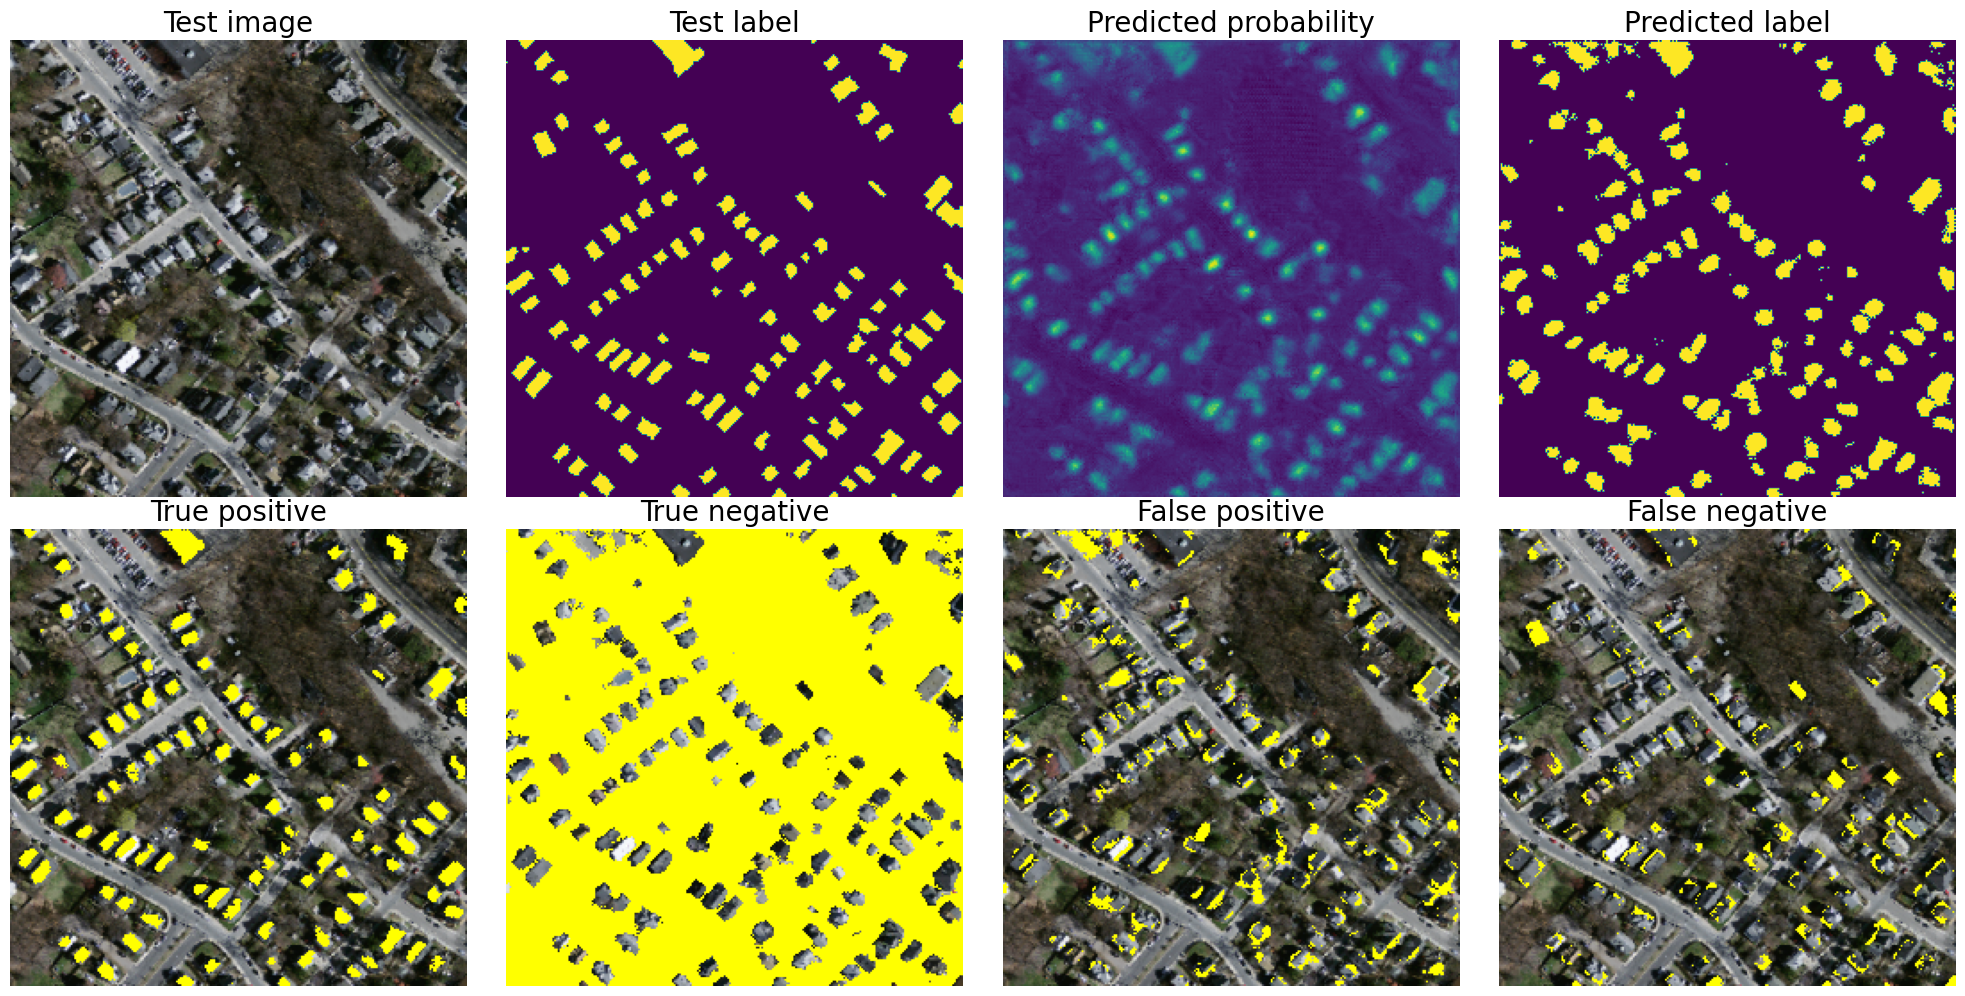

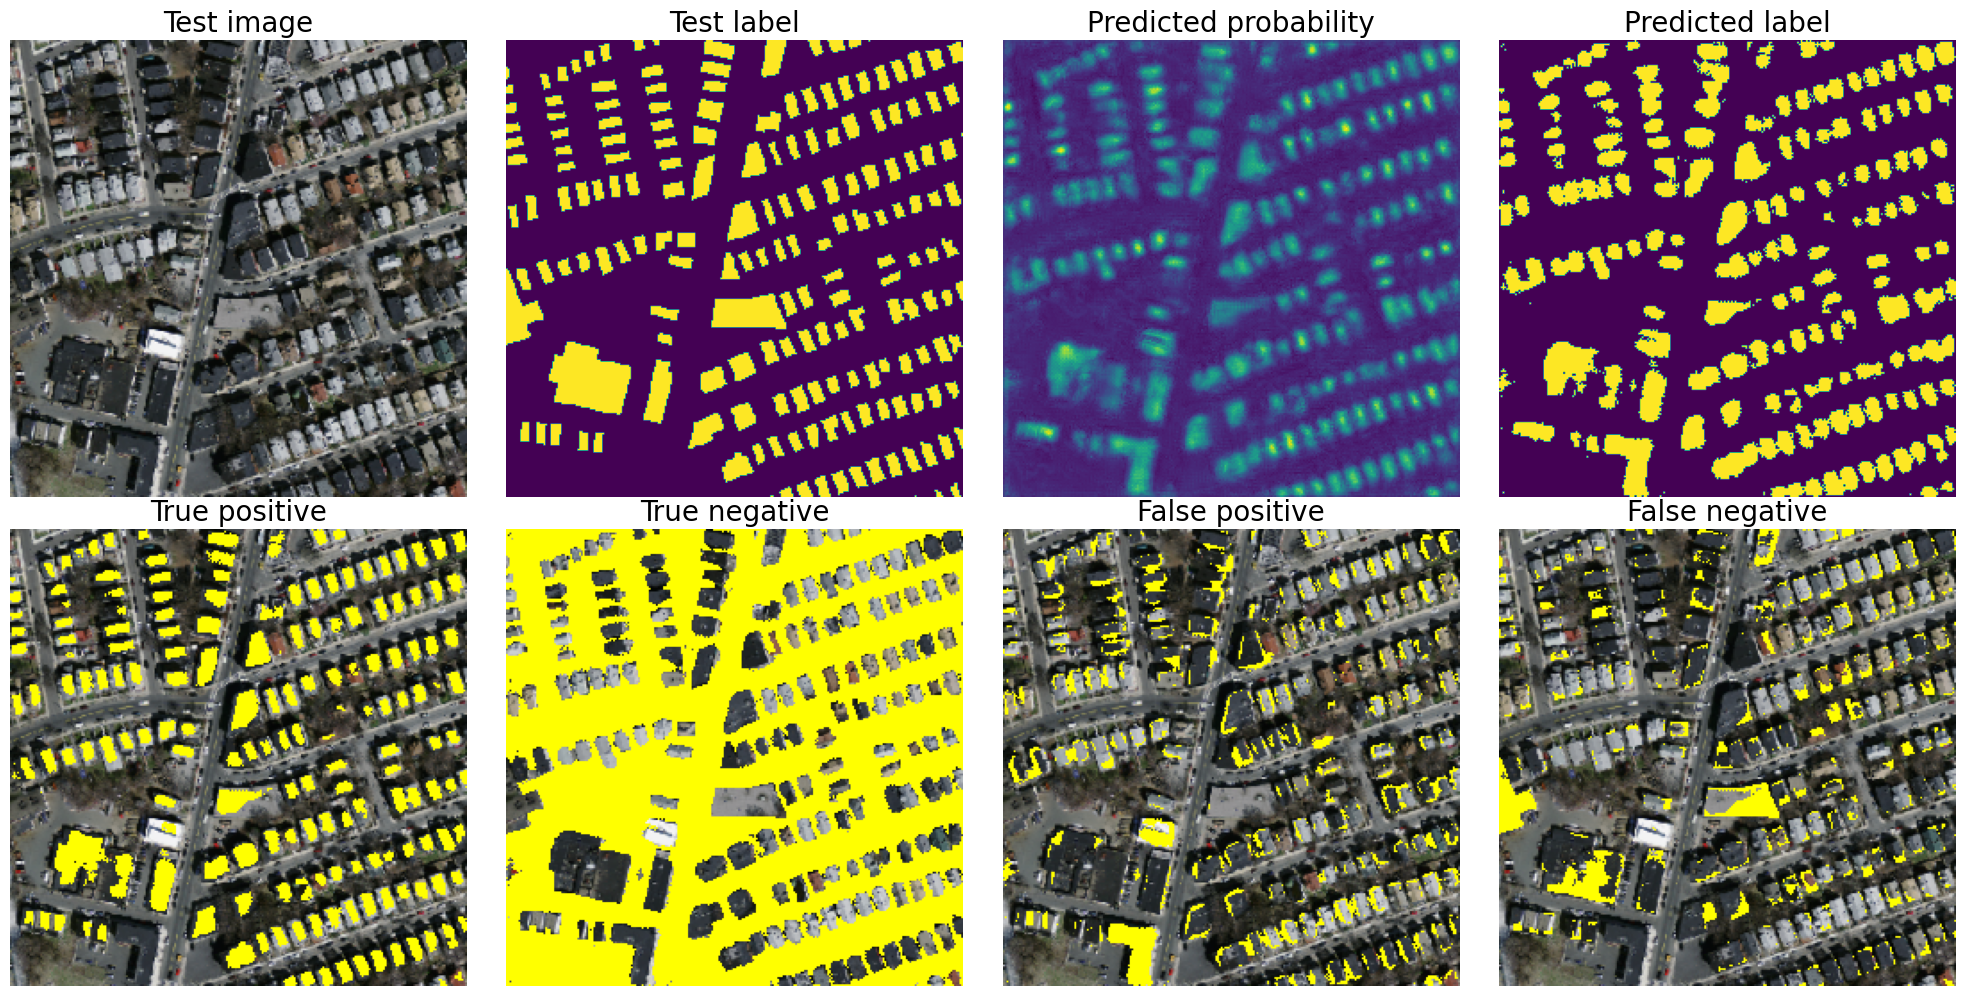

In [12]:
# Prédit les probabilités
scores_test = model.predict(images_test, batch_size=16, verbose=0)

# Calcule le seuil optimal
precision, recall, thresholds = skmetrics.precision_recall_curve(labels_test.flatten(), scores_test.flatten())
f1_scores = 2 * (precision * recall) / (precision + recall)
threshold = thresholds[np.argmax(f1_scores)]
del precision, recall, thresholds, f1_scores

# Predit les labels
predicts_test = scores_test >= threshold

# Calcule les statistiques de prédiction
for i in np.random.choice(range(len(images_test)), 2, replace=False):
    display_statistics(image_test=images_test[i], label_test=labels_test[i], score_test=scores_test[i], predict_test=predicts_test[i])
del i